# Goal of the project

The goal of this project is to control a 2D quadrotor to reach a target while avoiding obstacles using a learned policy. You wil have to create your own Custom environment using the [stable_baselines3](https://stable-baselines3.readthedocs.io/en/master/) library and train a RL agent using PPO.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from gymnasium.spaces import Box
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import numpy as np
import quadrotor
import math
import gymnasium
import os

The goal of this project is to learn a policy that can move the robot from any point to the red dot ($x^{\star} = [2, 0, 0, 0, 0, 0]^T$) while avoiding thee obstacles. The obstacles are represented by the black circles in the animation. You can check if the drone is in collision with an obstacle using the function ```quadrotor.check_collision```. 

## Create a RL environment
Using the [stable_baselines3](https://stable-baselines3.readthedocs.io/en/master/), create a [custom RL environment](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html) environment. You will have to follow the following steps:

1. Implement a step function than contrains the dynamics (you are free to use the ```quadrotor.next_state```) and a reward function. To speed-up the training, make sure to add a gravity compensation term in your dynamics (i.e. the drone should stay in place when the policy outputs zeros).
   The reward should be made of three terms:
   
- A positive term to incentivize the quadrotor to reach the target. You can start with a reward bounded between 0 and 1, e.g.
   $\operatorname{exp}(-\frac{1}{2} (x - x^{\star})Q(x - x^{\star}) -\frac{1}{2} (u - u_{\text{gravity}})R(u - u_{\text{gravity}}))$

   
- A large negative penality(e.g. -100)  if the robot get out of the following bounds:
$ p_x \in [-4, 4], \quad v_x \in [-10, 10] , \quad p_y \in [-4, 4] , \quad v_y \in [-10, 10] , \quad \theta \in [-2 \pi, 2 \pi] , \quad \omega \in [-10, 10] $.

 - A negative penalty if the robot hits the obstacle, e.g. -1. You should use the ```quadrotor.check_collision```.

Keep in mind that, in RL, the goal is to maximize a reward (and not minimize a cost like in Optimal Control).

2. Implement a reset function that initializes the state randomly. You can sample uniformly between $[-2, 2]$ for $p_x$ and $p_y$ and initialize the other terms to zero. Make sure to reject samples that are colliding with the obstacles using the ```quadrotor.check_collision```.

3. In the step function, stop the environment using ```truncated``` after 200 steps (Here is an [example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)).

4. In the step function, stop the environment if the drone goes outsite of the provided bounds using ```terminated``` (Here is an [example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)).

5. Make sure that your environment is well defined using the ```check_env``` function.
   
## Training a policy with PPO   
Train a policy with PPO and use the learned policy to define a controller. Make sure that you can reach the target while avoiding the obstacles starting from $x_0 = [-2, 0, 0, 0 ,0, 0]$

<br>
<br>

## **Solution**

**PPO Algorithm**  
PPO stands for Proximal policy evaluation. In this algorithm we directly optimize the policy by finding the approximate derivative of the cost function;

$\nabla J(\theta) = Exp[\sum^N_{n=0} \Psi_n \nabla log(\pi (u_n | x_n, \theta))]$

This means that the cost we are trying to minimize is approximated to be equal to:

$J(\theta) = Exp[\Psi_n log(\pi (u_n | x_n, \theta))]$ for each timestep

The function $\Psi$ can corresponds to or is directly proportional to the cost at a given timestep in PPO, depending on what you take as a baseline. 
Hence to get optimal control we must minimise the cost at every timestep.

In **RL terms** where we think of maximising the reward**, we have to maximise this cost at every step and setup a reward at every timestep of the PPO to make it train correctly.

$\bullet$ Setup the step function, which takes the current state and some control action chosen by the agent while training and returns the reward and next state.  
$\bullet$ We have setup the agent to get a positive exponential reward, close to 1 if its current states are near the desired states and close to 0 if the current states are far away.  
$\bullet$ A small negative reward of -2 is given if rotor collides with any obstructions.  
$\bullet$ A large negative reward of -100 is given if rotor leaves the bounds, this will force the model to explore options within desired bounds of states and controls.  
$\bullet$ We have also setup a terminate condition if the quadrotor leaves the desired bounds and a truncate condition if we reach max timesteps. This tells the agent to reset and start a new episode.

**Performance of the PPO model in training can be evaluated by the sum of all rewards, i.e. the reward per episode after some amount of total timesteps of training.**

In [2]:
class CustomEnv(gymnasium.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self):
        super().__init__()

        #Define an observation space and control space for the PPO agent to sample and train with.
        self.observation_space = Box(low = np.array([-20, -20, -20, -20, -20, -20]), high = np.array([20, 20, 20, 20, 20, 20]),
                                     shape = (6,), dtype= np.float64)
        self.action_space = Box(low = np.array([0, 0]), high = np.array([10, 10]), shape= (2,), dtype= np.float64)

        self.desired_state = np.array([2,0,0,0,0,0])
        self.grav_force = np.array([quadrotor.MASS*quadrotor.GRAVITY_CONSTANT/2, quadrotor.MASS*quadrotor.GRAVITY_CONSTANT/2])

        #Originally initialise a random state within some bound using reset function
        self.state, _ = self.reset()
        self.timestep = 0
        self.reward = 0
        self.terminated = False
        self.truncated = False

    def go_target(self, action):

        #Exponential function desired to give a reward of close to 1 at every timestep when states are very close to desired states and near 0 if far away
        n_states = self.state.shape[0]
        Q = np.eye(n_states)

        n_controls = self.action_space.shape[0]
        R = 0.01*np.eye(n_controls)

        return np.exp( (-1/2)*((self.state - self.desired_state)@Q@(self.state - self.desired_state)) - 
                      (1/2)*((action - self.grav_force)@R@(action - self.grav_force)))
    
    def exceed_bound(self):

        #Bound restrictions
        px, vx, py, vy, th, w = self.state
        if px <= -4 or px >= 4:
            return -100, True
        elif vx <= -10 or vx >= 10:
            return -100, True
        elif py <= -4 or py >= 4:
            return -100, True        
        elif vy <= -10 or vy >= 10:
            return -100, True
        elif th <= -2*math.pi or th >= 2*math.pi:
            return -100, True
        elif w <= -10 or w >= 10:
            return -100, True
        else:
            return 0, False

    def step(self, action):
        """Take a step in the environment."""

        #Get next state by function in quadrotor.py
        self.state =  quadrotor.next_state(self.state, action)

        incentive_reward = self.go_target(action) #reward for being closer to desired states

        #Bound penalty of -100 for going out of specified bounds and terminating episode.
        bound_penalty, self.terminated = self.exceed_bound()

        #Collision penalty of -2 for hitting obstacle
        collision_penalty = (-2 if quadrotor.check_collision(self.state) else 0)

        self.reward = incentive_reward + bound_penalty + collision_penalty

        #truncate if at 200 timesteps
        self.truncated = (True if self.timestep >= 200 else False)

        self.timestep +=1
        return self.state, self.reward, self.terminated, self.truncated, {}
    
    def reset(self, seed=None, options=None):
        while True:
            # Randomly sample position within position bounds
            px = np.random.uniform(-2, 2)
            py = np.random.uniform(-2, 2)

            state = np.array([px, 0, py, 0, 0, 0], dtype = np.float64)

            # Check for collision with obstacles
            if not quadrotor.check_collision(state):
                break

        #Return state and reset other values
        self.state = state
        self.reward = 0
        self.terminated = False
        self.truncated = False
        self.timestep = 0
        return self.state, {}

In [3]:
#Check if environment works
rotor_env = CustomEnv()
check_env(rotor_env)

c:\Applications\Python\Python311\Lib\site-packages\stable_baselines3\common\env_checker.py:461: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(
c:\Applications\Python\Python311\Lib\site-packages\stable_baselines3\common\env_checker.py:472: UserWarning: Your action space has dtype float64, we recommend using np.float32 to avoid cast errors.
  warnings.warn(


In [5]:
#Load model after selecting best reward model in models/ here already done and saved as model_fin
model_path = "model_fin.zip"
model = PPO.load(model_path)

c:\Applications\Python\Python311\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [6]:
def controller(x, t):
    actions, _ = model.predict(x)
    return actions

x_init = np.array([-2, 0, 0., 0 ,0, 0])
horizon_length = 200
t, state, u = quadrotor.simulate(x_init, controller, horizon_length)
quadrotor.animate_robot(state, u, save_mp4=False)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAh/1tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzE5MSA0NjEzYWMzIC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyNCAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
GjRliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/9/791p1zzw78KA2BJ
aqh8Cisz4sCaS273do3rE6Y/JhWMUQsmEaRU/Ij0ewp43OMPz7R2SPbm+68q6yIkr84mLavcb4tE
d070a0b9ZsTjkRA15H+YLuFUCQvHDIWte6k4kzfB4Yq1VXe3ycePau7Rj9tHaRN1WJ7N/1Z90Gn3
5PEJONCvPqkmhksanP5XpC7D218U8YWj4r7jtHkBqvdT8HuUUf+2M/Tg9cFZ5iBIp+ndP9p+33+U
JLnUdluVoTXMhVzsq3fe1AN9gVw6gXCXLV/VOOpLbR/wxSWB9Icl+r0E9gv6ua/d/99C6F3hQlL2
dlAptUEBMFne4OkfGm2RnQxxEHeFmv/l+ScnP07kNrXwHEWYjDczseY/c4vSTRR95J6BvXD318gF
r1VqdahPAPlsMYfOyIS+26dxWBdU4UwQr65LKtl7iYRrc5i/esy7mA72r3KrT2vHL9s5WfNQdncI
FhRbGANNL53Xrn1DvEkR3r5q3G2ZALdUX1OXEZPwh6sFXACmYP7/OQ9Gd3NSH4hKZysJjdSs1M6d
EGO/tvasAvV1Jeq/eoGjf4iD1/lxyOQ9QDrueaFnRanyU3P6/DNS6KkAH23kAERPXW96zwAVqiAq
Hd04rrbhdPULQhms11HsCV59Jfa+yp0Y0ywr4dFZ/7BC1zOAx68E2OZE7r9C4DoEdJOMvAEo4zXk
4/6OX7N9ZcgTP7BQvqgo+vmz56+Tm3NVWj58/3AtglyWW1u2IMgn0ucvVUMj2SfhDdc7zkI7GObn
DNrzCTjemDOsdFLpp6Z8vhzOxMbj4nvE9U8sR3eMbuiplTV1xeEJ4m/suVjz/viLKCV04RlL1MjH
ZVFPSOE/1s9ksVwfrKdGaGwJycB6sefyjEwWXQ/kxOBAiwic6dcKZ9U0pl07xQAXWd9WMXemTdYZ
V8Gixb6tSfKYvUcZWEkITmgUen3adbR8tBzHKpJKzWiZG8FoDGJMdZ+sBvNHKrhkGi+PhkFzUS38
846QRpJVLqY5zzn21dvve6TkJ0tDVYX4qbLehEbi6f8zD4Vvc4oifrkjo6aC70DwCZFhANKEOvjk
kZ0ydMRAx/niWfJoO3JOcbCqA6ZEz/zXSQDVI4Uf+LFb0FdFc61tZXMSeQ9+rBfY+GStlm0k+4W0
n1nMHmzrruv8qKlCb6t8JGsnzrCapKsEhxHvqpcua8FJGHACAWqXposHJ+lqfOlgxI59JuT5DS1j
7AD0gAQNK1oafGe4heUR5fflPSAClZ6rb2ESDmh4qV+napKGZYjm1GuRU43lqBySnRVNRy6O/Nqh
3pzVRzjnqaDz9ue86CVv0kwFAdpMHE9ftOLeHMVqR+kmBAPw8mN2dCmjRrOUDeSjd+Vg9SN1cJvV
zoLC3XkdrOkWuJskBSfkAAAUasmJTQsVaVLvBNluphTVeb5qwuv0JI6KJMc787ruAd+zx4bU5PJ0
uZMneTB0n04LdSPVphzJrbEjDYDf31eJxOn3ojTLzUehs7IxrCqe2jljLxTUVR60ued4AurtJUPI
WmNYIsEPTu6N33ZTqcSqkNt2br3EPwrpZ6i1/HBWLu3+n+OOW/4ANUNCV8wC4biN4glSK9ukQ0yP
iNe2ql+YD1/dyT08crRh+n6A15oV6isdrrNNfmUN4G6cTliOWCcJTJTEpiszsDNsx/7nD9MYtdtk
5RbbLM4EgOw3iIKVyJbQk2gYE04RjoLzD3NdMPVGn/ukccXVsqdVxLI9v8m7n5MeUP17aicZEQCK
XVsEIhaenO/5BANwTTXJZ6i5AlOE7Owvk6C0pg0Xd6eSACo2zrngms70bEzKx7S3SlMh/+b1s1/j
Hc31Mbp77OFZQSMIMtbNDsECmpkM1FYeuczy5tLp67fdxJd/DgXmlLjzKzHiKmb8naRixyzl+7Bg
AADpMUosKwtEvnbwXAZ7eAZYDtjhtxu7oLH7+KsRXqrritEzfHcM8I9tIS6gxBHtbJgUAEwmN0ns
cHeOgQtyHU51lfxQoPP7mqWhey9srzRlcVuvwS6M5eqzNQd+fxPXsUjtZgbPTGzu7mZoacUIt4Ct
6zV9bItB1AeVQZNdXW30EgmJrnrDfaNYaQW5zSCwVieOm/r8NsLLx7frUArw3FvMbEuoBiG4BQnn
Q1wumcAKBdpB1+5hs345h2vxzFvnYGIcwiYHLr6xhVM1S3BCBcTQSywmM3M7tQFY/pG1Cw7aVuUw
C/HZCjYv/wFzBEFDV+o1CvxrxktRi7yrgUf6T4yJifn1WD3yfH0PtbNS3z3ckQ3gFdJnSuHYG8dj
ivq82E4CTj2AnwWl8Q9+Ve6dhHBJmsxdm4wNo5e1Gwq0MwyYMXi4M9rx7F8u9irGgXofMAn8Pg75
sB8dWMr+JsoEmNw3VFAyqL4RLc0kXZcP/PxhiPIYZ5kjAblP/77FdDN5/28QH/390KD44evs9msW
TSuYx9TKdLjxLpytngsZ/

In [7]:
#Save values of state and control for optimal quadrotor trajectory

states = {"px": [], "vx": [], "py": [], "vy": [], "th": [], "w": []}
controls = {"u1": [], "u2": []}

x_t = np.array([-2, 0, 0., 0 ,0, 0])
for i in range(200):

    states["px"].append(x_t[0])
    states["vx"].append(x_t[1])
    states["py"].append(x_t[2])
    states["vy"].append(x_t[3])
    states["th"].append(x_t[4])
    states["w"].append(x_t[5])

    actions, _ = model.predict(x_t)

    controls["u1"].append(actions[0])
    controls["u2"].append(actions[1])

    x_next = quadrotor.next_state(x_t, actions)
    x_t = x_next

for i in range(len(states["th"])):
    if states["th"][i] > math.pi:
        states["th"][i] = states["th"][i] - 2*math.pi


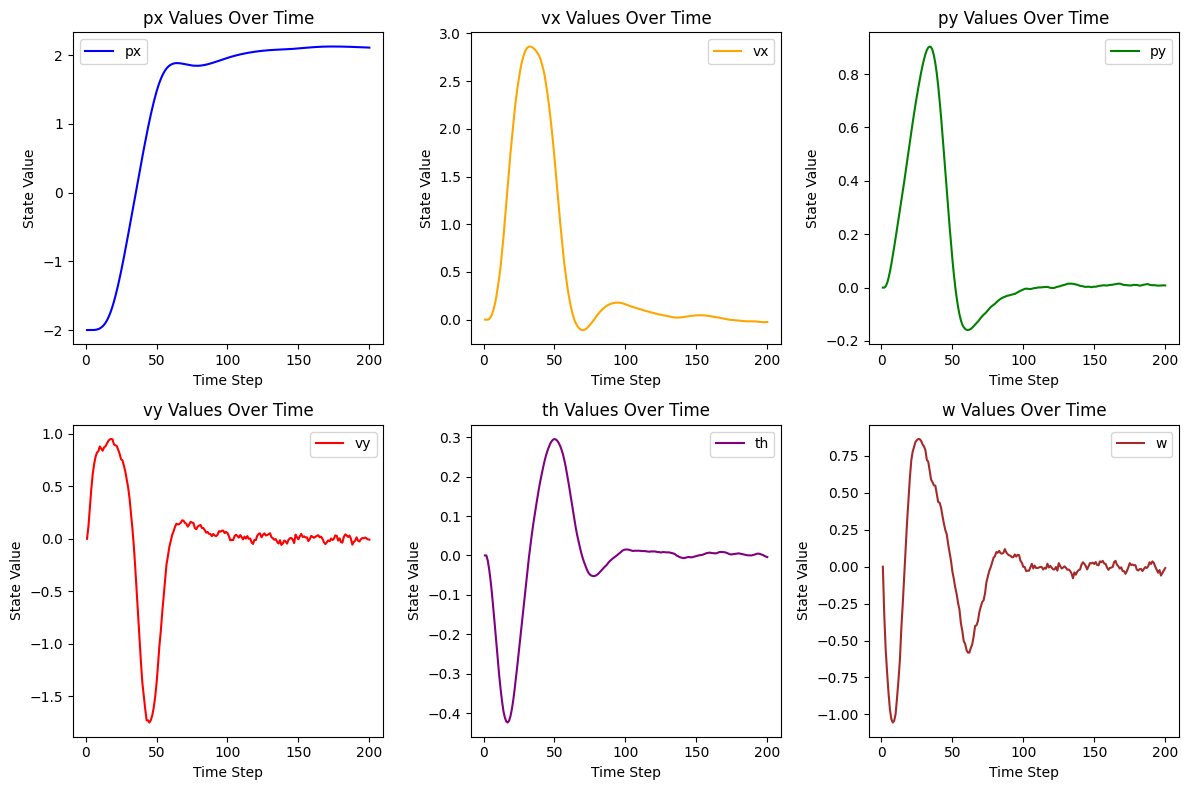

In [8]:
#Plotting states

time_steps = list(range(1, 201))

plt.figure(figsize=(12, 8))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for i, (state, values) in enumerate(states.items(), start=1):
    plt.subplot(2, 3, i) 
    plt.plot(time_steps, values, label=state, color=colors[i - 1])
    plt.title(f"{state} Values Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("State Value")
    plt.legend()

# Adjust layout for clarity
plt.tight_layout()
plt.show()

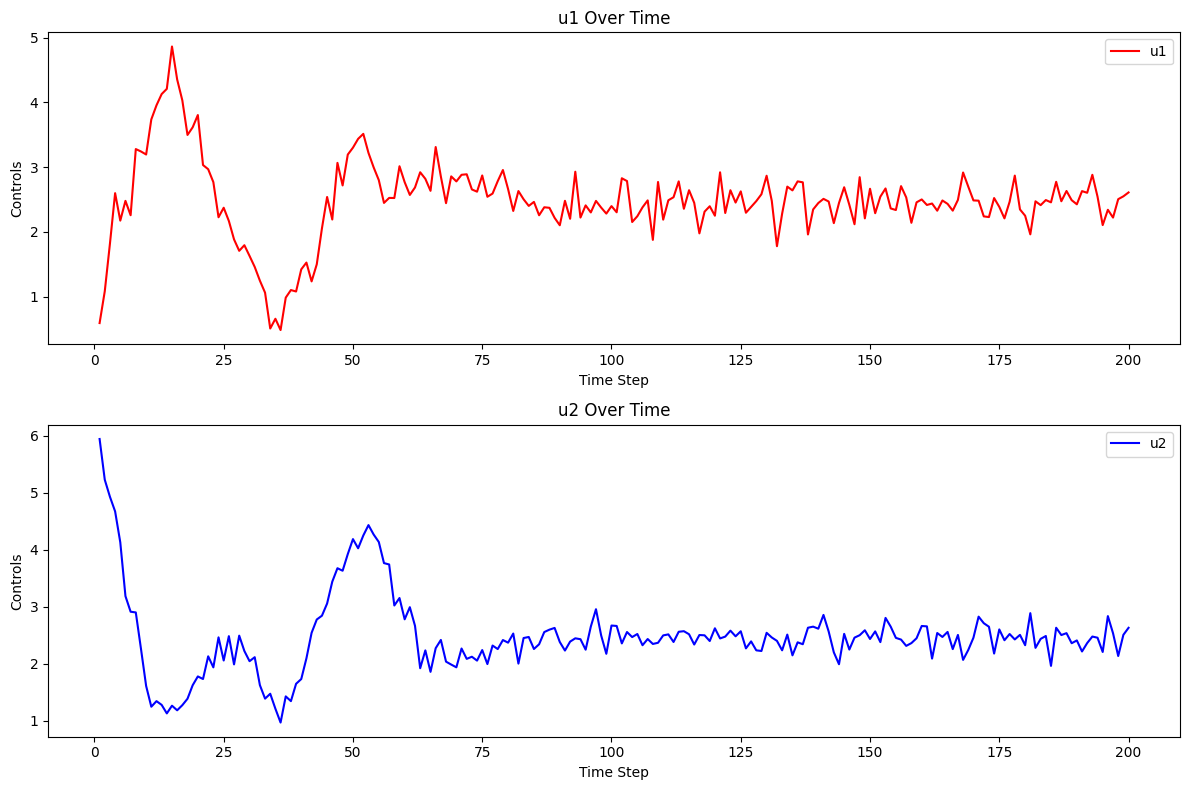

In [ ]:
#Plotting controls

plt.figure(figsize=(12, 8))

colors = ['red', 'blue']

for i, (control, values) in enumerate(controls.items(), start=1):
    plt.subplot(2, 1, i)  # Arrange in a 2x3 grid
    plt.plot(time_steps, values, label=control, color=colors[i - 1])
    plt.title(f"{control} Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Controls")
    plt.legend()

# Adjust layout for clarity
plt.tight_layout()
plt.show()

**We can see we first use a large u2 to push the quadrotor to the right and then there is a spike in u1 to make the quadrotor stop again.**

In [ ]:
models_dir = "models/PPO/"
logdir = "logs/PPO/"

if not os.path.exists(models_dir):
	os.makedirs(models_dir)

if not os.path.exists(logdir):
	os.makedirs(logdir)

#Initialise environment
env = CustomEnv()

#Initialise PPO model
model = PPO('MlpPolicy', env, verbose=1, tensorboard_log=logdir, device="cpu")

env.reset()
TIMESTEPS = 20000
iters = 0

#We save 80 models every 20k timesteps to save model at different training checkpoints
while iters <= 80:
	iters += 1
	model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="PPO")
	model.save(f"{models_dir}/{TIMESTEPS*iters}")